In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data.dataset import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt


# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = []
        self.class_names = os.listdir(main_dir)
        self.class_to_idx = {self.class_names[i]: i for i in range(len(self.class_names))}
        for class_name in self.class_names:
            class_dir = os.path.join(main_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.all_imgs.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc, class_idx = self.all_imgs[idx]
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, class_idx


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CustomDataset("/home/buddhadev/Buddhadev_Everything/Blood_Resnet18_classification/Erythroblast_detection_resnet_18/data", transform)

# Splitting dataset
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Creating data loaders
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)


In [3]:
# Define the VGG16 Model
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, len(dataset.class_names))

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transfer the model to GPU
vgg19 = vgg19.to(device)


/home/buddhadev/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/buddhadev/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda:0


In [4]:
# Initialize lists to monitor loss and accuracy
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

# Training Loop
for epoch in range(10):  # Adjust the number of epochs
    vgg19.train()
    running_loss, train_total, train_correct = 0.0, 0, 0

    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(train_accuracy)

    # Validation Phase
    vgg19.eval()
    valid_loss, valid_total, valid_correct = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg19(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_accuracy:.2f}%, \
Valid Loss: {valid_loss/len(validloader):.4f}, Valid Acc: {valid_accuracy:.2f}%")

print('Finished Training')


100%|█████████████████████████████████████████| 813/813 [04:35<00:00,  2.95it/s]


Epoch 1, Train Loss: 0.3557, Train Acc: 87.92%, Valid Loss: 0.0675, Valid Acc: 97.60%


100%|█████████████████████████████████████████| 813/813 [04:18<00:00,  3.14it/s]


Epoch 2, Train Loss: 0.0778, Train Acc: 97.52%, Valid Loss: 0.0710, Valid Acc: 97.63%


100%|█████████████████████████████████████████| 813/813 [04:16<00:00,  3.17it/s]


Epoch 3, Train Loss: 0.0520, Train Acc: 98.33%, Valid Loss: 0.0610, Valid Acc: 97.94%


100%|█████████████████████████████████████████| 813/813 [04:16<00:00,  3.18it/s]


Epoch 4, Train Loss: 0.0266, Train Acc: 99.12%, Valid Loss: 0.0726, Valid Acc: 98.15%


100%|█████████████████████████████████████████| 813/813 [04:16<00:00,  3.17it/s]


Epoch 5, Train Loss: 0.0180, Train Acc: 99.42%, Valid Loss: 0.0557, Valid Acc: 98.52%


100%|█████████████████████████████████████████| 813/813 [04:16<00:00,  3.17it/s]


Epoch 6, Train Loss: 0.0081, Train Acc: 99.74%, Valid Loss: 0.0729, Valid Acc: 98.31%


100%|█████████████████████████████████████████| 813/813 [04:31<00:00,  3.00it/s]


Epoch 7, Train Loss: 0.0176, Train Acc: 99.47%, Valid Loss: 0.0559, Valid Acc: 98.40%


100%|█████████████████████████████████████████| 813/813 [04:42<00:00,  2.88it/s]


Epoch 8, Train Loss: 0.0149, Train Acc: 99.55%, Valid Loss: 0.0609, Valid Acc: 98.37%


100%|█████████████████████████████████████████| 813/813 [04:33<00:00,  2.97it/s]


Epoch 9, Train Loss: 0.0100, Train Acc: 99.72%, Valid Loss: 0.0742, Valid Acc: 98.15%


100%|█████████████████████████████████████████| 813/813 [04:35<00:00,  2.95it/s]


Epoch 10, Train Loss: 0.0081, Train Acc: 99.72%, Valid Loss: 0.0522, Valid Acc: 98.74%
Finished Training


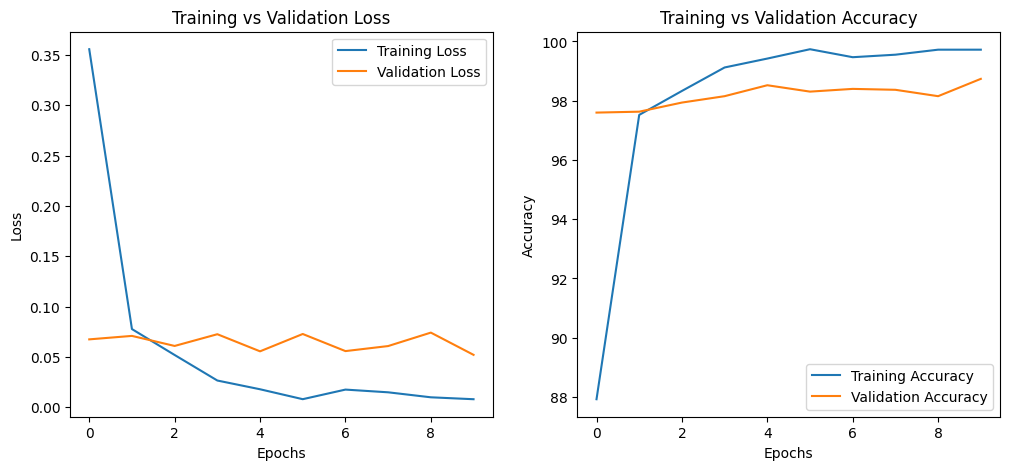

In [5]:
# Save the model
torch.save(vgg19.state_dict(), 'vgg19_trained_model.pth')

# Plotting training and validation graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [6]:
test_dataset = CustomDataset("/home/buddhadev/Buddhadev_Everything/Blood_Resnet18_classification/Erythroblast_detection_resnet_18/test", transform)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [7]:
# Ensure the model is in evaluation mode
vgg19.eval()

test_correct = 0
test_total = 0
predictions = []
actuals = []

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        predictions.extend(predicted.view(-1).cpu().numpy())
        actuals.extend(labels.view(-1).cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 98.71%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


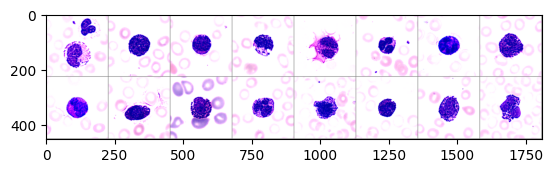

Actual labels:  basophil basophil basophil basophil
Predicted labels:  basophil basophil basophil basophil


In [8]:
import matplotlib.pyplot as plt
import torchvision 
import numpy as np
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)


# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print('Actual labels: ', ' '.join(f'{test_dataset.class_names[labels[j]]}' for j in range(4)))
print('Predicted labels: ', ' '.join(f'{test_dataset.class_names[predictions[j]]}' for j in range(4)))


In [9]:
def gather_images_and_predictions(dataset, model, num_images_per_class):
    model.eval()
    images, actuals, predictions = [], [], []
    class_count = {class_idx: 0 for class_idx in range(len(dataset.class_names))}

    with torch.no_grad():
        for image, actual in dataset:
            if class_count[actual] < num_images_per_class:
                image = image.to(device)
                output = model(image.unsqueeze(0))
                _, predicted = torch.max(output, 1)

                images.append(image.cpu())
                actuals.append(actual)
                predictions.append(predicted.cpu().item())

                class_count[actual] += 1
                if all(count >= num_images_per_class for count in class_count.values()):
                    break

    return images, actuals, predictions



In [10]:
images_per_class = 2  # Adjust as needed
test_images, actual_labels, predicted_labels = gather_images_and_predictions(test_dataset, vgg19, images_per_class)


In [11]:
def imshow(img, ax=None):
    # Unnormalize the image for display
    img = img / 2 + 0.5
    npimg = img.numpy()
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')  # Turn off axis
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')

        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

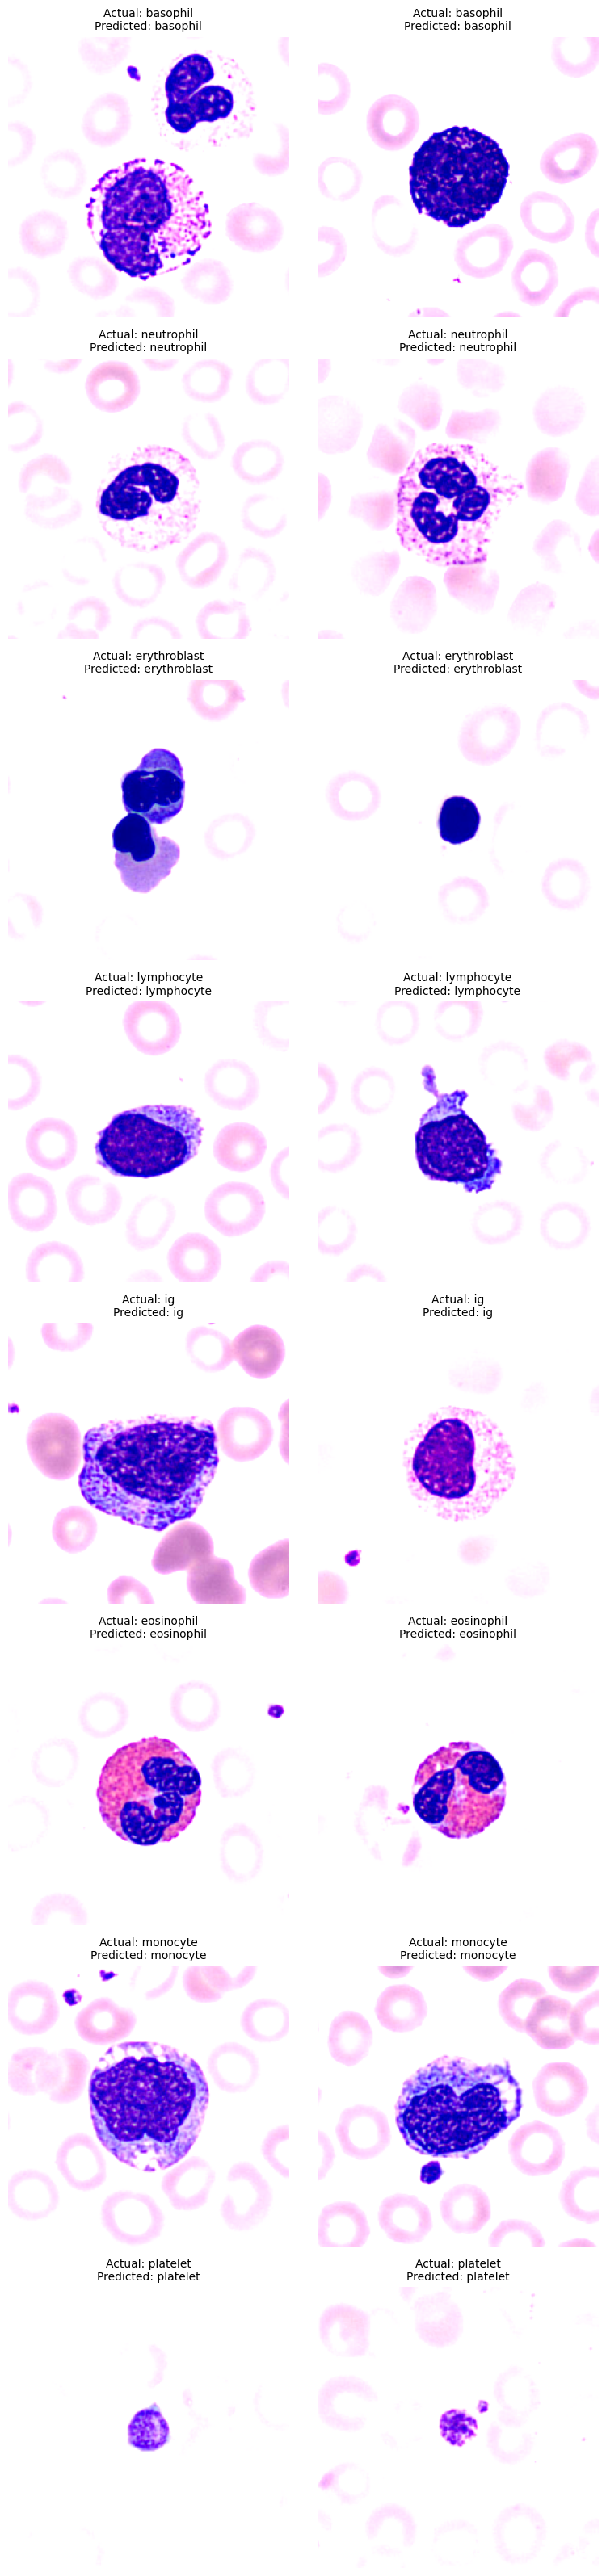

In [12]:
# Display images with actual and predicted labels
rows = len(test_dataset.class_names)
cols = images_per_class
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for i in range(len(test_images)):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    
    # Show image
    imshow(test_images[i], ax=ax)

    # Set title with actual and predicted labels
    actual_label = test_dataset.class_names[actual_labels[i]]
    predicted_label = test_dataset.class_names[predicted_labels[i]]
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [13]:
!pip install seaborn

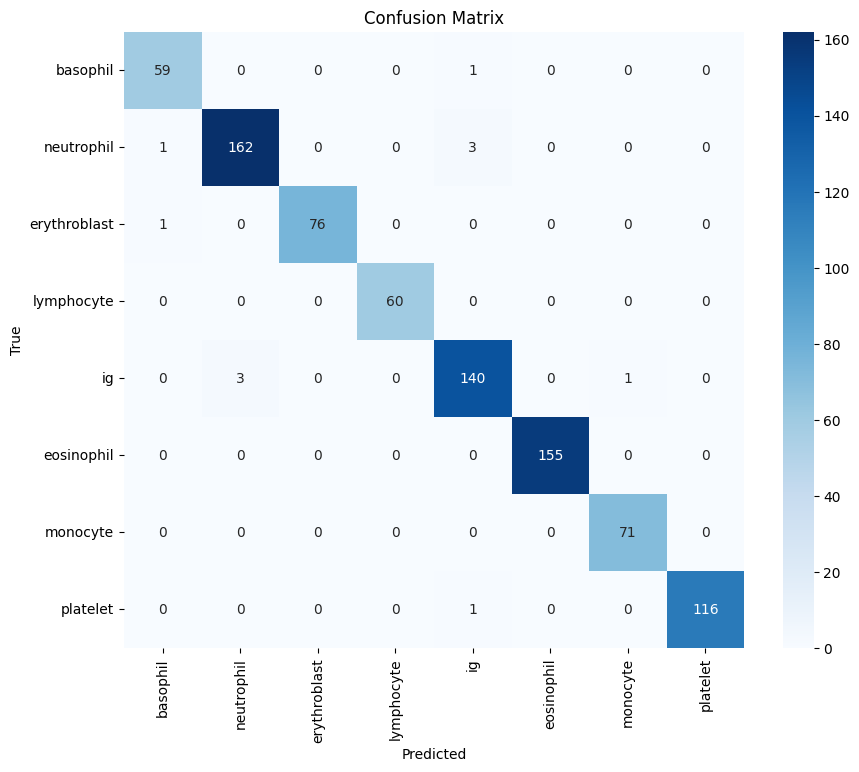

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(actuals, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
